In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
from einops import rearrange, repeat

In [2]:
from typing import Optional, Any, Sequence
import dataclasses

In [3]:
import matplotlib.pyplot as plt

# Implementations

## MultiHeadAttention

In [4]:
class MultiHeadAttention(hk.Module):
    def __init__(
        self,
        num_heads: int,
        key_size: Optional[int]=None,
        value_size: Optional[int]=None,
        model_size: Optional[int]=None,
    ):
        super().__init__()
        self.num_heads = num_heads
        self.key_size = key_size or (model_size // num_heads) if model_size is not None else None
        self.value_size = value_size or key_size
        self.model_size = model_size or (key_size * num_heads) if key_size is not None else None
        assert self.model_size or self.key_size is not None, "must provide at least one of `key_value`, `model_size`"
        assert key_size * num_heads == model_size, "Must satisfy `key_size * num_heads == model_size`"
    
    @hk.transparent
    def __linear(
        self,
        x: jnp.ndarray, # [b, n_q, embed_size] 
        head_size: int,
    ) -> jnp.ndarray: # [b, num_head, n_q, head_size]
        '''
        map a single embedded input sequence into a size `num_heads` collection of featured tensors
        shape change: [b, n, embed_size] -> [b, n, num_heads*head_size] -> [b, num_heads, n, head_size]
        - b: batch_size
        - n: sequence length
        '''
        y = hk.Linear(self.num_heads * head_size)(x) # shape of y: [b, n, num_heads*head_size]
        return rearrange(y, 'b n (h d) -> b h n d', h=self.num_heads) # shape of return: [b, num_heads, n, head_size]
    
    def __call__(
        self,
        q_input: jnp.ndarray, # shape: [b, n_q, embed_size]
        k_input: jnp.ndarray, # shape: [b, n_k, embed_size]
        v_input: jnp.ndarray, # shape: [b, n_k, embed_size]
        mask: Optional[jnp.ndarray] = None, # shape: [b, 1, n_q, n_k]
    ) -> jnp.ndarray:
        '''
        - map embedded input sequences (q_input, k_input, v_input) into multi-headed featured tensors (q, k, v)
        - compute attention weights by "compatible function of queries and keys": w_ij = (q_ik*k_jk) / sqrt(key_size)
        - compute "weighted sum of values": ret_ij = w_ik * v_kj
        - map concatenated "weighted sum of values" to a feature tensor
        '''
        q = self.__linear(q_input, self.key_size) # shape: [b, n_q, embed_size] -> [b, num_head, n_q, key_size]
        k = self.__linear(k_input, self.key_size) # shape: [b, n_k, embed_size] -> [b, num_head, n_k, key_size]
        v = self.__linear(v_input, self.value_size) # shape: [b, n_k, embed_size] -> [b, num_head, n_k, value_size]
        # Q: why n_k not n_v?
        # A: key value pairs are one to one mapping, n_v == n_k
        
        attn_weights = jnp.einsum('bhik, bhjk -> bhij', q, k) # shape: [b, h, n_q, key_size] @ [b, h, n_k, key_size] -> [b, h, n_q, n_k]
        attn_weights /= jnp.sqrt(self.key_size)
        
        if mask is not None:
            assert mask.ndim == attn_weights.ndim, f"Mask dimensionality {mask.ndim} must match attention weights dimensionality {attn_weights.ndim}"
            attn_weights = jnp.where(mask, attn_weights, -1e30)
        attn_weights = jax.nn.softmax(attn_weights) # [b, h, n_q, n_k]
        
        weighted_v = jnp.einsum('bhik, bhkd -> bhid', attn_weights, v) # shape: [b, h, n_q, n_k] @ [b, h, n_k, value_size] -> [b, h, n_q, value_size]
        weighted_v = rearrange(weighted_v, 'b h n v -> b n (h v)') # shape: [b, h, n_q, value_size] -> [b, n_q, h*value_size]
        
        v_ret = hk.Linear(self.model_size)(weighted_v) # shape: [b, n_q, h*value_size] -> [b, n_q, model_size]
        return v_ret

## FFN

In [5]:
class FFN(hk.Module):
    def __init__(
        self,
        model_size: int,
        hidden_size: int,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.wb1 = hk.Linear(hidden_size) # W1 & b1
        self.wb2 = hk.Linear(model_size) # W2 & b2
        self.dropout_rate = dropout_rate
        
    def __call__(
        self,
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        y = self.wb1(x) # xW1 + b1
        y = jax.nn.relu(y) # max(0, xW1 + b1)
        y = self.wb2(y) # max(0, xW1 + b1)W2 + b2
        y = hk.dropout(hk.next_rng_key(), self.dropout_rate, y)
        return y

## Positional Encoding

In [6]:
@dataclasses.dataclass
class PositionalEncoding(hk.initializers.Initializer):
    '''
    - has the same model_size as embedding
    - use sine and cosine functions of different frequencies:
        - PE(pos, 2i) = sin(pos/10000^(2i/model_size))
        - PE(pos, 2i+1) = cos(pos/10000^(2i/model_size))
    '''
    def __call__(
        self,
        shape: Sequence[int],
        dtype: Any = np.float32,
    ) -> jnp.ndarray:
        max_len, model_size = shape
        pe = np.zeros((max_len, model_size), dtype=dtype)
        # pos = np.expand_dims(np.arange(0, max_len), 1)
        pos = np.arange(0, max_len)[:,np.newaxis]
        div_term = np.exp(np.arange(0, model_size, 2) * 
                         -(np.log(10000.) / model_size)) # 1/(10000^(2i/model_size)) = 10000^(-2i/model_size) = exp(-2i * ln(10000) / model_size)
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)
        pe = jnp.array(pe[np.newaxis:])
        pe = jax.lax.stop_gradient(pe) # this is a frozen parameter
        
        return pe
        
        # print(type(x))
        # x = x + self.pe[:, :x.size(1)]
        # return hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

## Embeddings

In [41]:
class Embeddings(hk.Module):
    def __init__(
        self,
        model_size: int,
        vocab_size: int,
        embedding_matrix: Optional[jnp.ndarray] = None,
    ):
        '''
        if embedding-tying, then use generator's weights as embedding_matrix
        '''
        super().__init__()
        if embedding_matrix is None:
            self.embed = hk.Embed(
                vocab_size=vocab_size,
                embed_dim=model_size,
            )
        else:
            self.embed = hk.Embed(
                embedding_matrix=embedding_matrix
            )
        self.model_size = model_size
    
    def get_embedding_matrix(
        self,
    ) -> jnp.ndarray:
        return self.embed.embeddings
    
    def __call__(
        self,
        x: jnp.ndarray # shape [b, n]
    ) -> jnp.ndarray: # shape [b, n, embed_size], embed_size == model_size
        '''
        - In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation
        - "In the embedding layers, we multiply those weights by sqrt(model_size)"
        '''    
        return self.embed(x) * jnp.sqrt(self.model_size)

## TransformerConfig

In [8]:
@dataclasses.dataclass
class TransformerConfig:
    '''
    global hyperparameters used to minimize obnoxious kwarg plumbing
    '''
    input_vocab_size: int
    output_vocab_size: int
    model_size: int = 512
    num_heads: int = 8
    num_layers: int = 6
    hidden_size: int = 2048
    dropout_rate: float = 0.1
    src_pad_token: int = 0
    tgt_pad_token: int = 0
    
    def __post_init__(self):
        '''
        sanity check and compute missing hyperparameters
        '''
        # recall the `rearrange` function in multi-head attention: `b n (hd) -> b h n d`
        self.key_size = self.model_size // self.num_heads
        # this is because the transformer is designed to have same-size key and value, 
        #     not because attention module should have same-size key and value
        self.value_size = self.key_size
    
    def __repr__(self):
        '''
        print out all hyperparameters
        '''
        return str(self.__dict__)

## Encoder

In [9]:
def layer_norm(x: jnp.ndarray) -> jnp.ndarray:
    '''
    Applies a unique LayerNorm to x with default settings.
    '''
    ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
    return ln(x)

@dataclasses.dataclass
class Encoder(hk.Module):
    config: TransformerConfig
    
    def __post_init__(
        self,
    ):
        super().__init__()
        config = self.config
        self.embedding = Embeddings(
            model_size=config.model_size,
            vocab_size=config.input_vocab_size,
        )
        
    def __call__(
        self,
        inputs: jnp.ndarray, # [b, n]
        src_mask: Optional[jnp.ndarray] = None, # [b, 1, n, n]
        is_training: bool = True,
    ) -> jnp.ndarray:
        config = self.config
        dropout_rate = config.dropout_rate if is_training else 0

        # embedding the input sequence
        seq_len = inputs.shape[-1]
        pos_embed = hk.get_parameter("positional_embeddings", 
                                     [seq_len, config.model_size],
                                     init=PositionalEncoding())
        h_embed = self.embedding(inputs.astype('int32')) + pos_embed
        # we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks
        h_embed = hk.dropout(hk.next_rng_key(), dropout_rate, h_embed) # [b, n, embed_size], embed_size == model_size
        
        h = h_embed
        for _ in range(config.num_layers):
            
            # multi-head attention SUBLAYER
            attn_block = MultiHeadAttention(
                num_heads=config.num_heads,
                key_size=config.key_size,
                model_size=config.model_size,
            )
            # We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
            h_attn = attn_block(h, 
                                h, 
                                h, 
                                mask=src_mask) # [b, n, model_size]
            h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn)
            h = layer_norm(h + h_attn)
            
            # position-wise ffn SUBLAYER
            ffn_block = FFN(
                model_size=config.model_size,
                hidden_size=config.hidden_size,
                dropout_rate=config.dropout_rate,
            )
            # We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
            h_dense = ffn_block(h) # [b, n, model_size]
            h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
            h = layer_norm(h + h_dense) # [b, n, model_size]
        
        return h

## Decoder

In [44]:
@dataclasses.dataclass
class Decoder(hk.Module):
    config: TransformerConfig
    
    def __post_init__(
        self,
    ):
        super().__init__()
        config = self.config
        self.embedding = Embeddings(
            model_size=config.model_size,
            vocab_size=config.output_vocab_size,
        )
    
    def __call__(
        self,
        inputs: jnp.ndarray, # [b, n_k]
        enc_outputs: jnp.ndarray, # [b, n_q, model_size], encoder output of src_embed
        tgt_mask: Optional[jnp.ndarray] = None, # [b, 1, n_k, n_k]
        tgt_src_mask: Optional[jnp.ndarray] = None, # [b, 1, n_k, n_q]
        is_training: bool = True,
    ) -> jnp.ndarray:
        config = self.config
        dropout_rate = config.dropout_rate if is_training else 0

        # embedding the input sequence
        seq_len = inputs.shape[-1]
        pos_embed = hk.get_parameter("positional_embeddings", 
                                     [seq_len, config.model_size],
                                     init=PositionalEncoding())
        h_embed = self.embedding(inputs.astype('int32')) + pos_embed
        # we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks
        h_embed = hk.dropout(hk.next_rng_key(), dropout_rate, h_embed) # [b, n_k, embed_size], embed_size == model_size
        
        h = h_embed # [b, n_k, embed_size]
        for _ in range(config.num_layers):
            
            # multi-head attention SUBLAYER
            attn_block = MultiHeadAttention(
                num_heads=config.num_heads,
                key_size=config.key_size,
                model_size=config.model_size,
            )
            # We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
            h_attn = attn_block(h,
                                h,
                                h,
                                mask=tgt_mask)
            h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn) # [b, n_k, model_size]
            h = layer_norm(h + h_attn)
            
            # multi-head cross attention SUBLAYER
            cross_attn_block = MultiHeadAttention(
                num_heads=config.num_heads,
                key_size=config.key_size,
                model_size=config.model_size,
            )
            # We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
            h_attn = cross_attn_block(h, # [b, n_k, model_size]
                                      enc_outputs, # [b, n_q, model_size]
                                      enc_outputs, 
                                      mask=tgt_src_mask)
            h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn) # [b, n_k, model_size]
            h = layer_norm(h + h_attn)
            
            # position-wise ffn SUBLAYER
            ffn_block = FFN(
                model_size=config.model_size,
                hidden_size=config.hidden_size,
                dropout_rate=config.dropout_rate,
            )
            # We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
            h_dense = ffn_block(h) # [b, n_k, model_size]
            h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
            h = layer_norm(h + h_dense) # [b, n_k, model_size]
            
        return h

## Transformer

In [25]:
@dataclasses.dataclass
class Transformer(hk.Module):
    config: TransformerConfig
    is_training: bool
    
    def __post_init__(self):
        '''
        setup each components, embeddings is called on the fly
        '''
        super().__init__() # for dataclass decorated modules, this still should be called manually
        config = self.config
        
        self.encoder = Encoder(config=config)
        self.decoder = Decoder(config=config)
        
        def generator(x: jnp.ndarray): # weight sharing between embeddings and the final linear layer
            embedding_matrix = self.decoder.embedding.get_embedding_matrix()
            return jnp.dot(x, embedding_matrix.T)
        
        self.generator = generator
        
    def __call__(
        self,
        src_inputs: jnp.ndarray, # [b, n_q]
        tgt_inputs: jnp.ndarray, # [b, n_k]
        src_mask: Optional[jnp.ndarray] = None, # [b, n_q]
        tgt_mask: Optional[jnp.ndarray] = None, # [b, n_k]
        is_training: bool = True,
    ) -> jnp.ndarray:
        
        if is_training != self.is_training:
            self.is_training = is_training
        print(f'model is in {"training" if self.is_training else "evaluation"} mode.')
        src_pad_token = self.config.src_pad_token
        tgt_pad_token = self.config.tgt_pad_token
        
        # ============= encoder =============
        if src_mask is None:
            _src_mask = jnp.einsum('bi, bj -> bij', src_inputs!=src_pad_token, src_inputs!=src_pad_token)[:, None, :] # shape [b, n_q] -> [b, n_q, n_q] -> [b, 1, n_q, n_q]
        else:
            _src_mask = jnp.einsum('bi, bj -> bij', src_mask, src_mask)[:, None, :] # shape [b, n_q] -> [b, n_q, n_q] -> [b, 1, n_q, n_q]
        
        enc_outputs = self.encoder(
            inputs=src_inputs,
            src_mask=_src_mask,
            is_training=self.is_training,
        ) # [b, n_q, model_size]
        
        # ============= decoder =============
        if tgt_mask is None:
            _tgt_mask = jnp.einsum('bi, bj -> bij', tgt_inputs!=tgt_pad_token, tgt_inputs!=tgt_pad_token)[:, None, :] # shape [b, n_k] -> [b, n_k, n_k] -> [b, 1, n_k, n_k]
        else:
            _tgt_mask = jnp.einsum('bi, bj -> bij', tgt_mask, tgt_mask)[:, None, :] # shape [b, n_k] -> [b, n_k, n_k] -> [b, 1, n_k, n_k]
        seq_len = tgt_inputs.shape[-1]
        # causal_mask = np.tril(np.ones_like(_tgt_mask)) # [b, 1, n_k, n_k]
        causal_mask = np.tril(np.ones((1, 1, seq_len, seq_len))) # [b, 1, n_k, n_k]
        _tgt_mask = _tgt_mask * causal_mask
        if tgt_mask is None:
            tgt_src_mask = jnp.einsum('bi, bj -> bij', tgt_inputs!=tgt_pad_token, src_inputs!=src_pad_token)[:, None, :] # shape [b, n_k, n_q] -> [b, 1, n_k, n_q]
        else:
            tgt_src_mask = jnp.einsum('bi, bj -> bij', tgt_mask, src_mask)[:, None, :] # shape [b, n_k, n_q] -> [b, 1, n_k, n_q]
        
        dec_outputs = self.decoder(
            inputs=tgt_inputs,
            enc_outputs=enc_outputs,
            tgt_mask=_tgt_mask,
            tgt_src_mask=tgt_src_mask,
            is_training=self.is_training,
        ) # [b, n_k, model_size]
        
        return self.generator(dec_outputs) # shape [b, n_k, vocab_size]

# Test modules

In [4]:
from model import *

## TransformerConfig

In [5]:
# TransformerConfig
configuration = TransformerConfig(
    input_vocab_size=25007,
    output_vocab_size=25007,
    model_size=512,
    num_heads=8,
    num_layers=2,
    hidden_size=1024,
    dropout_rate=0.1
)
print(configuration)

{'input_vocab_size': 25007, 'output_vocab_size': 25007, 'model_size': 512, 'num_heads': 8, 'num_layers': 2, 'hidden_size': 1024, 'dropout_rate': 0.1, 'key_size': 64, 'value_size': 64}


## positional encoding

<class 'jaxlib.xla_extension.DeviceArray'>
<class 'jaxlib.xla_extension.DeviceArray'>
CPU times: user 0 ns, sys: 1.71 ms, total: 1.71 ms
Wall time: 1.67 ms


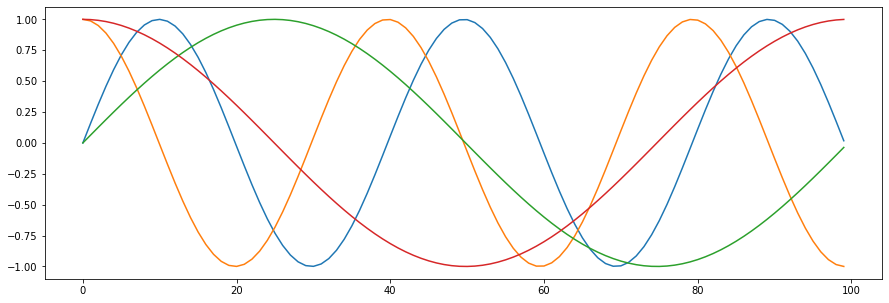

In [6]:
# test positional embedding correctness
def forward_fn(embed):
    _, seq_len, model_size = embed.shape
    pos_embed = hk.get_parameter("positional_embeddings", [seq_len, model_size], init=PositionalEncoding())
    print(type(pos_embed))
    return embed + pos_embed 

forward = hk.transform(forward_fn)
rngkey = jax.random.PRNGKey(42)
dummy_x = jnp.zeros((1, 100, 20))
params = forward.init(rng = rngkey, embed=dummy_x)
%time output = forward.apply(params, rng=rngkey, embed=dummy_x)
plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), output[0, :, 4:8])

## Embeddings

In [7]:
# Embeddings
def forward_fn(inputs):
    embed = Embeddings(model_size=512, vocab_size=50200)
    return embed(inputs)

forward = hk.transform(forward_fn)
rngkey = jax.random.PRNGKey(42)
dummy_x = repeat(np.arange(10), 'i -> c i', c=3)
params = forward.init(rng = rngkey, inputs=dummy_x)
%time output = forward.apply(params, rng=rngkey, inputs=dummy_x)

CPU times: user 6.78 ms, sys: 0 ns, total: 6.78 ms
Wall time: 5.83 ms


In [8]:
output.shape

(3, 10, 512)

## FFN

In [9]:
# FFN: [b, n, model_size] -> [b, n, model_size]
def forward_fn(x):
    ffn = FFN(
        model_size=configuration.model_size,
        hidden_size=configuration.hidden_size,
        dropout_rate=configuration.dropout_rate,
    )
    return ffn(x)

forward = hk.transform(forward_fn)
rngkey = jax.random.PRNGKey(42)
dummy_x = jnp.ones((2, 10, configuration.model_size))
params = forward.init(rng = rngkey, x=dummy_x)
%time output = forward.apply(params, rng=rngkey, x=dummy_x)

CPU times: user 9.39 ms, sys: 4.64 ms, total: 14 ms
Wall time: 12.8 ms


In [10]:
output.shape

(2, 10, 512)

In [11]:
jnp.array_equal(dummy_x, output)

DeviceArray(False, dtype=bool)

## MultiHeadAttention

In [12]:
def forward_fn(
    q: jnp.ndarray, # shape: [b, n_q, embed_size]
    k: jnp.ndarray, # shape: [b, n_k, embed_size]
    v: jnp.ndarray, # shape: [b, n_k, embed_size]
    mask: Optional[jnp.ndarray] = None, # shape: [b, 1, n_q, n_k]
):
    key_size = k.shape[-1] // configuration.num_heads
    value_size = v.shape[-1] // configuration.num_heads
    mha = MultiHeadAttention(
        num_heads=configuration.num_heads,
        key_size=key_size,
        value_size=value_size,
        model_size=configuration.model_size,
    )
    return mha(q, k, v, mask)

forward = hk.transform(forward_fn)
rngkey = jax.random.PRNGKey(42)
dummy_q = jnp.ones((2, 15, configuration.model_size))
dummy_k = jnp.ones((2, 12, configuration.model_size))
dummy_v = jnp.ones((2, 12, configuration.model_size*2))
params = forward.init(rng=rngkey, q=dummy_q, k=dummy_k, v=dummy_v)
%time output = forward.apply(params, rng=rngkey, q=dummy_q, k=dummy_k, v=dummy_v)

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 9.59 ms


In [13]:
output.shape

(2, 15, 512)

## Encoder

In [14]:
def forward_fn(
    src_inputs: jnp.ndarray, # [b, n_q]
    src_mask: Optional[jnp.ndarray] = None, # [b, 1, n_q, n_q]
    is_training: bool = True,
):
    
    key_size = configuration.model_size // configuration.num_heads
    
    encoder = Encoder(config=configuration)
    
    return encoder(src_inputs, src_mask, is_training)

forward = hk.transform(forward_fn)
rngkey = jax.random.PRNGKey(42)
src_inputs = np.ones((2, 1000))
src_inputs[1,500:600] = 0
src_mask = jnp.einsum('bi, bj -> bij', src_inputs>0, src_inputs>0)[:, None, :] # shape [b, n] -> [b, n, n] -> [b, 1, n, n]


params = forward.init(rng = rngkey, src_inputs=src_inputs, src_mask=src_mask, is_training=True)
%time output = forward.apply(params, rng=rngkey, src_inputs=src_inputs, src_mask=src_mask, is_training=True)

CPU times: user 42.9 ms, sys: 6.36 ms, total: 49.3 ms
Wall time: 38 ms


In [15]:
%time enc_outputs = forward.apply(params, rng=rngkey, src_inputs=src_inputs, src_mask=src_mask, is_training=True)

CPU times: user 59.5 ms, sys: 6.35 ms, total: 65.9 ms
Wall time: 51.6 ms


In [16]:
enc_outputs.shape

(2, 1000, 512)

In [17]:
jnp.array_equal(output,enc_outputs)

DeviceArray(True, dtype=bool)

## Decoder

In [18]:
def forward_fn(
    tgt_inputs: jnp.ndarray, # [b, n_k, embed_size], embed_size == model_size
    enc_outputs: jnp.ndarray, # [b, n_q, model_size], encoder output of src_embed
    tgt_mask: Optional[jnp.ndarray] = None, # [b, 1, n_k, n_k]
    tgt_src_mask: Optional[jnp.ndarray] = None, # [b, 1, n_k, n_q]
    is_training: bool = True,
):
    
    key_size = configuration.model_size // configuration.num_heads
    
    decoder = Decoder(config=configuration)
    
    return decoder(
        tgt_inputs, enc_outputs, tgt_mask, tgt_src_mask, is_training
    )

forward = hk.transform(forward_fn)
rngkey = jax.random.PRNGKey(42)
tgt_inputs = np.ones((2, 800))
tgt_inputs[1,700:] = 0

tgt_mask = jnp.einsum('bi, bj -> bij', tgt_inputs>0, tgt_inputs>0)[:, None, :] # shape [b, 1, n_k, n_k]
tgt_src_mask = jnp.einsum('bi, bj -> bij', tgt_inputs>0, src_inputs>0)[:, None, :] # shape [b, 1, n_k, n_q]

params = forward.init(rng = rngkey, tgt_inputs=tgt_inputs, enc_outputs=enc_outputs, tgt_mask=tgt_mask, tgt_src_mask=tgt_src_mask, is_training=True)

In [19]:
%time dec_outputs = forward.apply(params, rng=rngkey, tgt_inputs=tgt_inputs, enc_outputs=enc_outputs, tgt_mask=tgt_mask, tgt_src_mask=tgt_src_mask, is_training=True)

CPU times: user 108 ms, sys: 2.69 ms, total: 111 ms
Wall time: 89.4 ms


In [20]:
dec_outputs.shape

(2, 800, 512)

## Transformer

In [21]:
src_inputs.shape

(2, 1000)

In [22]:
tgt_inputs.shape

(2, 800)

In [23]:
def forward_fn(
    src_inputs: jnp.ndarray,
    tgt_inputs: jnp.ndarray,
    is_training: bool,
    config: TransformerConfig,
):
    print(config)
    model = Transformer(
        config=config,
        is_training=is_training,
    )
    return model(src_inputs, tgt_inputs, is_training)

forward = hk.transform(forward_fn)
rngkey = jax.random.PRNGKey(42)

params = forward.init(rng = rngkey, src_inputs=src_inputs, tgt_inputs=tgt_inputs, is_training=True, config=configuration)

{'input_vocab_size': 25007, 'output_vocab_size': 25007, 'model_size': 512, 'num_heads': 8, 'num_layers': 2, 'hidden_size': 1024, 'dropout_rate': 0.1, 'key_size': 64, 'value_size': 64}
model is in training mode.


In [24]:
params['transformer/~/decoder/~/embeddings/~/embed']['embeddings'].shape

(25007, 512)

In [25]:
%time output = forward.apply(params, rng=rngkey, src_inputs=src_inputs, tgt_inputs=tgt_inputs, is_training=True, config=configuration)

{'input_vocab_size': 25007, 'output_vocab_size': 25007, 'model_size': 512, 'num_heads': 8, 'num_layers': 2, 'hidden_size': 1024, 'dropout_rate': 0.1, 'key_size': 64, 'value_size': 64}
model is in training mode.
CPU times: user 150 ms, sys: 20.2 ms, total: 170 ms
Wall time: 140 ms


In [26]:
output.shape

(2, 800, 25007)

# Training

In [ ]:
# TransformerConfig
configuration = TransformerConfig(
    vocab_size=128, # since we are using the ASCII
    model_size=512,
    num_heads=8,
    num_layers=6,
    hidden_size=2048,
    dropout_rate=0.1
)
configuration

TypeError: TransformerConfig.__init__() got an unexpected keyword argument 'vocab_size'

In [ ]:
from typing import NamedTuple
import optax

In [ ]:
@dataclasses.dataclass
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    rng: jnp.DeviceArray
    step: jnp.DeviceArray

In [ ]:
def forward_fn(
    src_inputs: jnp.ndarray,
    tgt_inputs: jnp.ndarray,
    is_training: bool,
    config: TransformerConfig,
):
    model = Transformer(
        config=config,
        is_training=is_training,
    )
    return model(src_inputs, tgt_inputs)

In [ ]:
GRAD_CLIP_VALUE = 1
LEARNING_RATE = 3e-4

optimizer = optax.chain(
    optax.clip_by_global_norm(GRAD_CLIP_VALUE),
    optax.adam(LEARNING_RATE)
)

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

In [ ]:
from tokenizers.trainers import BpeTrainer
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [ ]:
from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

In [ ]:
from datasets import load_dataset

# wendarray wmt18
dataset = load_dataset("wmt14", 'de-en', split="train")

In [ ]:
dataset[0]

In [ ]:
def batch_iterator(dataset):
    for i in dataset:
        yield i["text"]

tokenizer.train_from_iterator(
    iterator=batch_iterator(dataset),
)

In [ ]:
@hk.transform
def loss_fn(data) -> jnp.ndarray:
    
    logits = forward_fn(
        
    )